# Counterfactuals Model 1

In [70]:
import pandas as pd
import numpy as np
import xgboost
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from joblib import Parallel, delayed

In [71]:
modeling_df = pd.read_parquet('../data/cdc_scraper/counterfactual_modeling_df.parquet')

In [72]:
modeling_vars = ['unemployment_rate_2020',
'median_household_income_2019',
'poverty_frac_2019',
'no_high_school',
'high_school_only',
'college_only',
'voted_biden',
'percent_hispanic',
'percent_non_hispanic_black',
'percent_non_hispanic_white',
'face_masks_required_in_public_Public mask mandate',
'moving_cases_lag_1',
'moving_cases_lag_2',
'moving_cases_lag_3',
'moving_cases_lag_4',
'moving_cases_lag_5',
'moving_cases_lag_6',
'estimated_hesitant',
'estimated_strongly_hesitant',
'pct_fully_vaccinated',
'weekday_0',
'weekday_1',
'weekday_2',
'weekday_3',
'weekday_4',
'weekday_5',
'weekday_6',
'year_2020',
'year_2021',
'year_2022',
'month_1',
'month_10',
'month_11',
'month_12',
'month_2',
'month_3',
'month_4',
'month_5',
'month_6',
'month_7',
'month_8',
'month_9'
]

# Model Tuning

In [73]:
modeling_df_sample = modeling_df.sample(500000)
X = modeling_df_sample[modeling_vars]
y = modeling_df_sample['moving_cases_per_100k']

In [74]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,a
        'seed': 0
    }

In [75]:
def objective(space):
    clf=xgboost.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    #evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X, y,
            #eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(X)
    accuracy = mean_squared_error(y,pred)
    print ("SCORE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }

In [42]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

SCORE:                                                                                                                                                                                                      
305.63215372438236                                                                                                                                                                                          
SCORE:                                                                                                                                                                                                      
326.4298169255063                                                                                                                                                                                           
SCORE:                                                                                                                                                                              

In [44]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6307822531567241, 'gamma': 7.031887606448105, 'max_depth': 18.0, 'min_child_weight': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 0.5433848893739188}


In [45]:
colsample_bytree = best_hyperparams['colsample_bytree']
gamma = best_hyperparams['gamma']
max_depth = int(best_hyperparams['max_depth'])
min_child_weight = int(best_hyperparams['min_child_weight'])
reg_alpha = best_hyperparams['reg_alpha']
reg_lambda = best_hyperparams['reg_lambda']

In [46]:
model = xgboost.XGBRegressor(
    colsample_bytree= colsample_bytree,
    gamma=gamma,
    max_depth= max_depth,
    min_child_weight= min_child_weight,
    reg_alpha= reg_alpha,
    reg_lambda= reg_lambda
)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6307822531567241, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=7.031887606448105, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=18, max_leaves=0, min_child_weight=0,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.0, reg_lambda=0.5433848893739188, ...)

In [48]:
pd.DataFrame(model.feature_importances_,modeling_vars)

,0
unemployment_rate_2020,0.004764
median_household_income_2019,0.005764
poverty_frac_2019,0.002920
no_high_school,0.003589
high_school_only,0.001967
college_only,0.003539
voted_biden,0.004761
percent_hispanic,0.004912
percent_non_hispanic_black,0.002846
percent_non_hispanic_white,0.002789


# Run Predictions

In [63]:
def run_forward_mask(df,model):
    df['change_points']= np.where(df['face_masks_required_in_public_No public mask mandate']!=df['face_masks_required_in_public_No public mask mandate'].shift(1).bfill(),1,0)
    change_imd =df.index.get_loc(df.index[df['change_points'] == 1][0])
    dates = df.iloc[change_imd:,5].unique()
    preds = []
    all_dfs = []
    for i, date in enumerate(dates):
        xx = df[df['date']==date].copy()
        xx.loc[:,'face_masks_required_in_public_Public mask mandate'] = 1
        if i ==0:

            preds.append(model.predict(xx[modeling_vars])[0])

            current = model.predict(xx[modeling_vars])[0]
            delta_1 = xx['moving_cases_lag_1'].values[0]
            delta_2 = xx['moving_cases_lag_2'].values[0]
            delta_3 = xx['moving_cases_lag_3'].values[0]
            delta_4 = xx['moving_cases_lag_4'].values[0]
            delta_5 = xx['moving_cases_lag_4'].values[0]
        else:
            xx['moving_cases_lag_1'] = preds[i-1]
            xx['moving_cases_lag_2'] = delta_1
            xx['moving_cases_lag_3'] = delta_2
            xx['moving_cases_lag_4'] = delta_3
            xx['moving_cases_lag_5'] = delta_4
            xx['moving_cases_lag_6'] = delta_5


            preds.append(model.predict(xx[modeling_vars])[0])

            current = model.predict(xx[modeling_vars])[0]
            delta_1 = xx['moving_cases_lag_1'].values[0]
            delta_2 = xx['moving_cases_lag_2'].values[0]
            delta_3 = xx['moving_cases_lag_3'].values[0]
            delta_4 = xx['moving_cases_lag_4'].values[0]
            delta_5 = xx['moving_cases_lag_5'].values[0]
    results_df = pd.DataFrame({'date':dates,'mask_requirement' : preds})
    return results_df

def run_forward_no_mask(df,model):
    df['change_points']= np.where(df['face_masks_required_in_public_No public mask mandate']!=df['face_masks_required_in_public_No public mask mandate'].shift(1).bfill(),1,0)
    change_imd =df.index.get_loc(df.index[df['change_points'] == 1][0])
    dates = df.iloc[change_imd:,5].unique()
    preds = []
    all_dfs = []
    for i, date in enumerate(dates):
        xx = df[df['date']==date].copy()
        xx.loc[:,'face_masks_required_in_public_Public mask mandate'] = 0
        if i ==0:

            preds.append(model.predict(xx[modeling_vars])[0])

            current = model.predict(xx[modeling_vars])[0]
            delta_1 = xx['moving_cases_lag_1'].values[0]
            delta_2 = xx['moving_cases_lag_2'].values[0]
            delta_3 = xx['moving_cases_lag_3'].values[0]
            delta_4 = xx['moving_cases_lag_4'].values[0]
            delta_5 = xx['moving_cases_lag_4'].values[0]
        else:
            xx['moving_cases_lag_1'] = preds[i-1]
            xx['moving_cases_lag_2'] = delta_1
            xx['moving_cases_lag_3'] = delta_2
            xx['moving_cases_lag_4'] = delta_3
            xx['moving_cases_lag_5'] = delta_4
            xx['moving_cases_lag_6'] = delta_5


            preds.append(model.predict(xx[modeling_vars])[0])

            current = model.predict(xx[modeling_vars])[0]
            delta_1 = xx['moving_cases_lag_1'].values[0]
            delta_2 = xx['moving_cases_lag_2'].values[0]
            delta_3 = xx['moving_cases_lag_3'].values[0]
            delta_4 = xx['moving_cases_lag_4'].values[0]
            delta_5 = xx['moving_cases_lag_5'].values[0]
    results_df = pd.DataFrame({'date':dates,'no_mask_requirement' : preds})
    return results_df
    
def run_for_fips(df,fips_code_text):
    try:
        df = df[df['fips_code_text']==fips_code_text].copy()
        mask_preds = run_forward_mask(df,model)
        no_mask_preds = run_forward_no_mask(df,model)
        melted_df = mask_preds.merge(no_mask_preds).melt(id_vars='date')
        melted_df['fips_code_text'] = fips_code_text
        melted_df['state_code'] = df['state_code'].unique()[0]
        return melted_df
    except:
        pass


In [78]:
%%time
all_runs_list = Parallel(n_jobs=6)(delayed(run_for_fips)(modeling_df,i) for i in tqdm(modeling_df['fips_code_text'].unique()))

 20%|████████████████████████████████▎                                                                                                                                   | 558/2832 [12:39<43:54,  1.16s/it]/Users/achilleasghinis/.venvs/mda-project/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2832/2832 [1:06:00<00:00,  1.40s/it]


CPU times: user 35min 2s, sys: 10min 39s, total: 45min 42s
Wall time: 1h 6min 12s


In [86]:
from plotnine importm *

In [105]:
all_runs = pd.concat(all_runs_list)
state_counterfactuals = all_runs.groupby(['date','variable','state_code']).agg({'value':'sum'}).reset_index()
state_actuals = modeling_df.groupby(['date','state_code']).agg({'moving_cases_per_100k':'sum'}).reset_index()
state_actuals.columns = ['date','state_code','value']
state_actuals['variable'] = 'actual'
final_results = pd.concat([state_counterfactuals,state_actuals[['date','variable','state_code','value']]])

In [125]:
final_results.to_csv('counterfactual_results_model_1.csv',index=False)

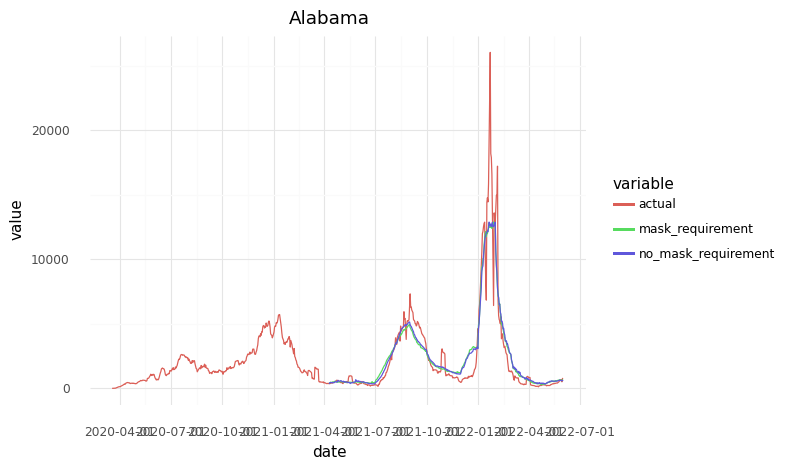

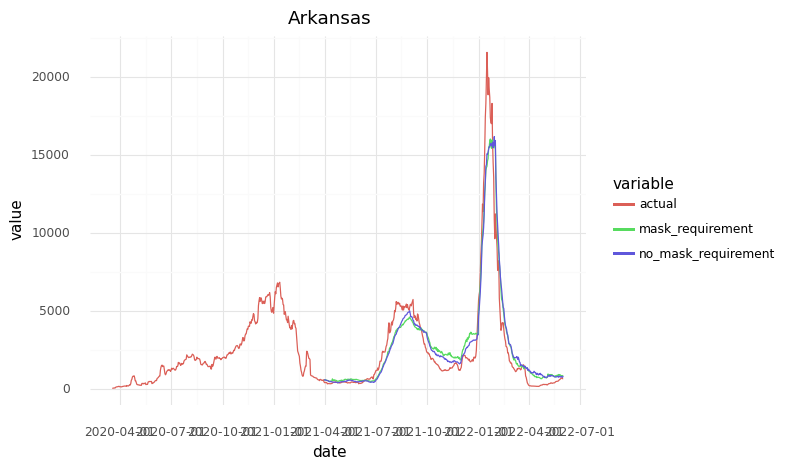

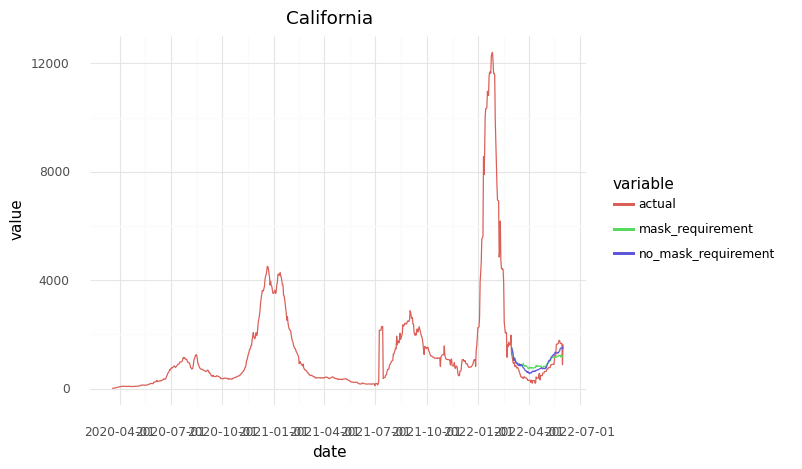

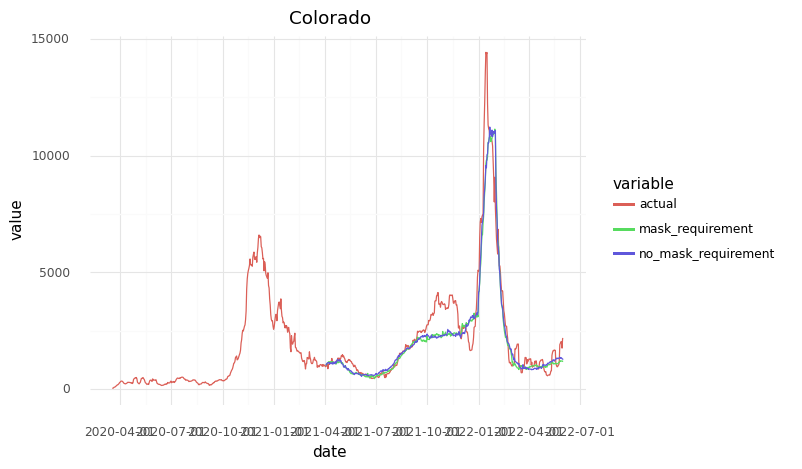

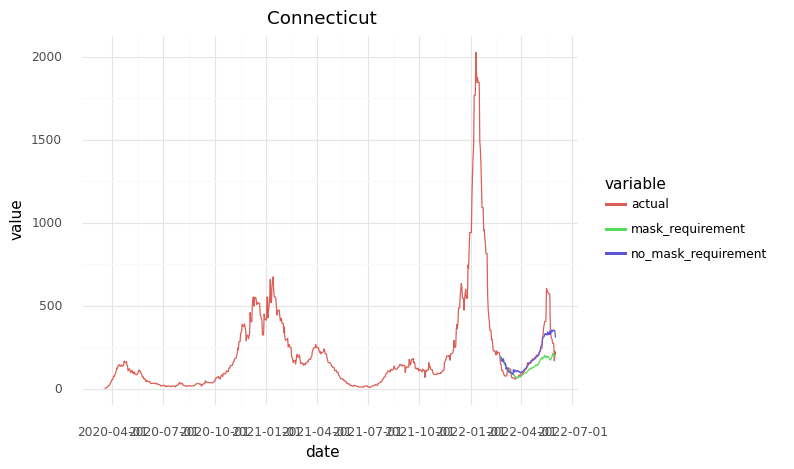

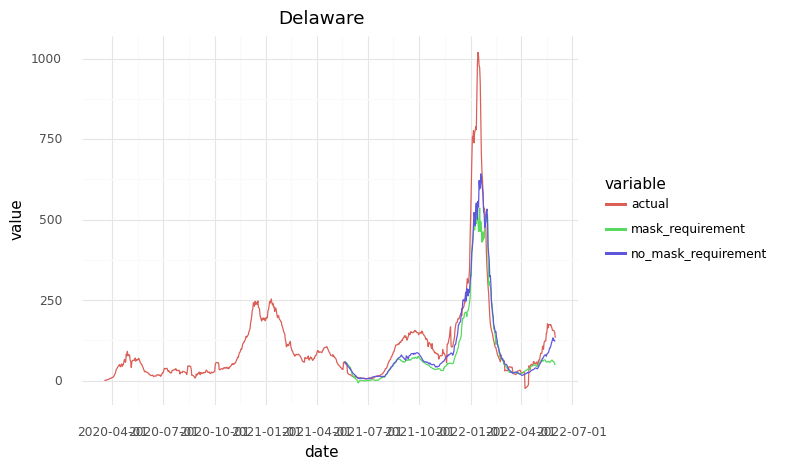

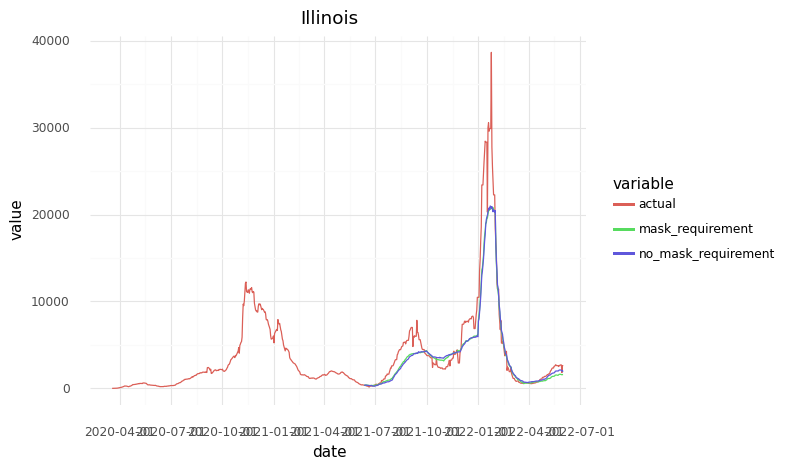

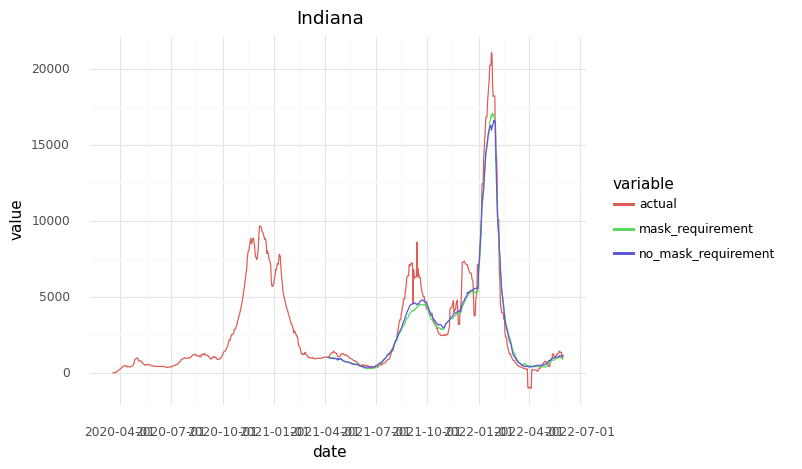

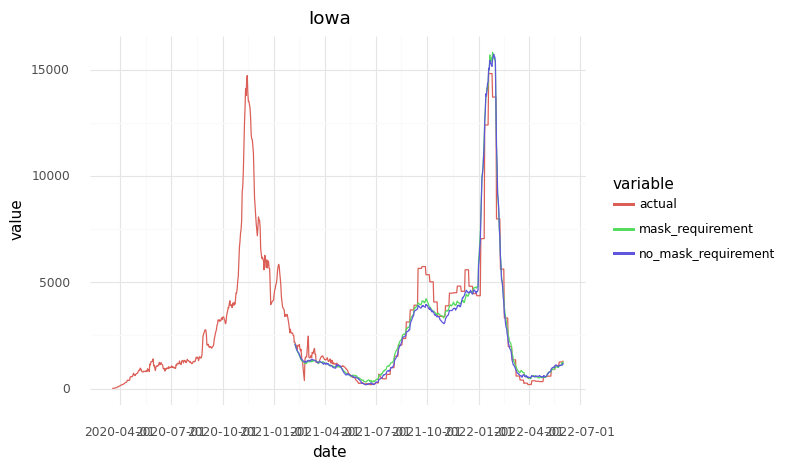

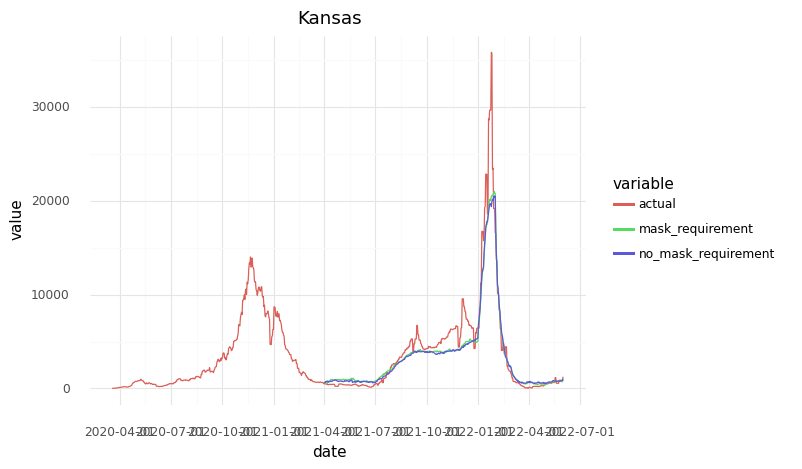

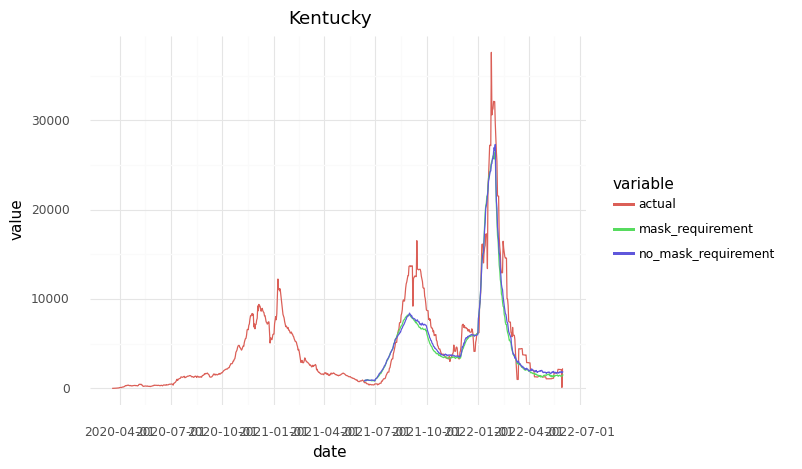

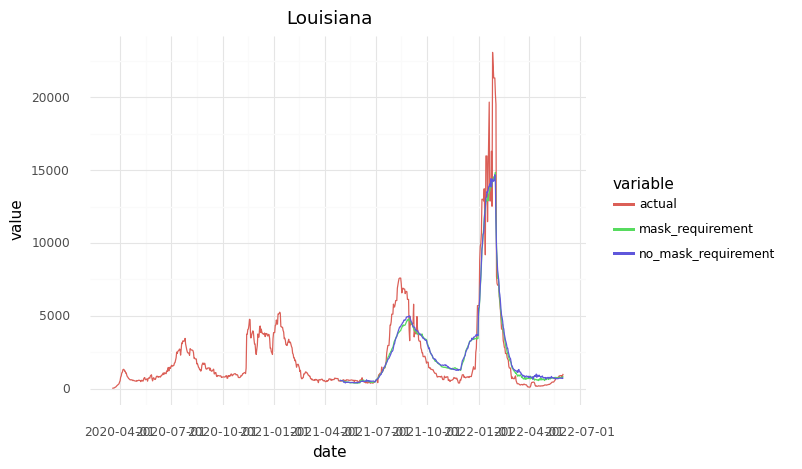

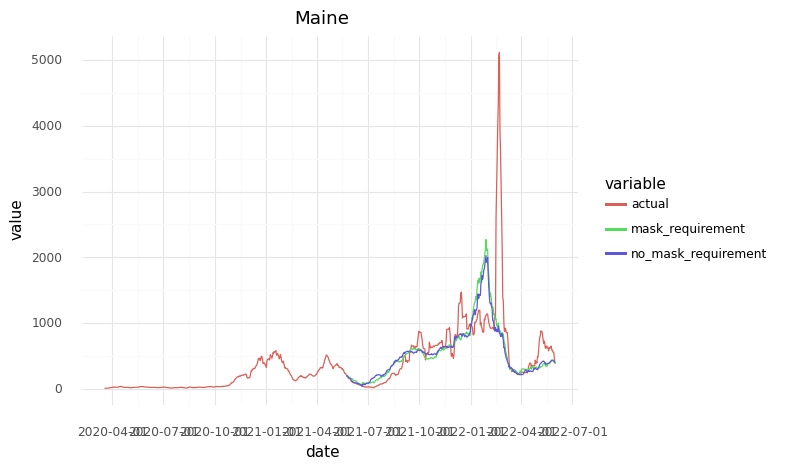

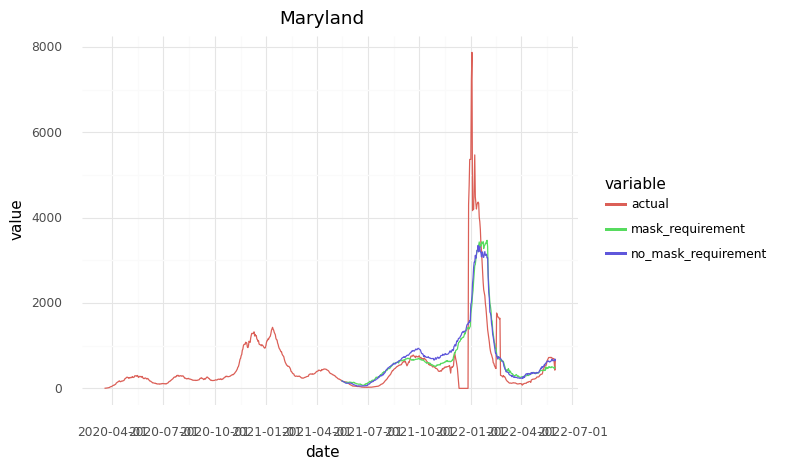

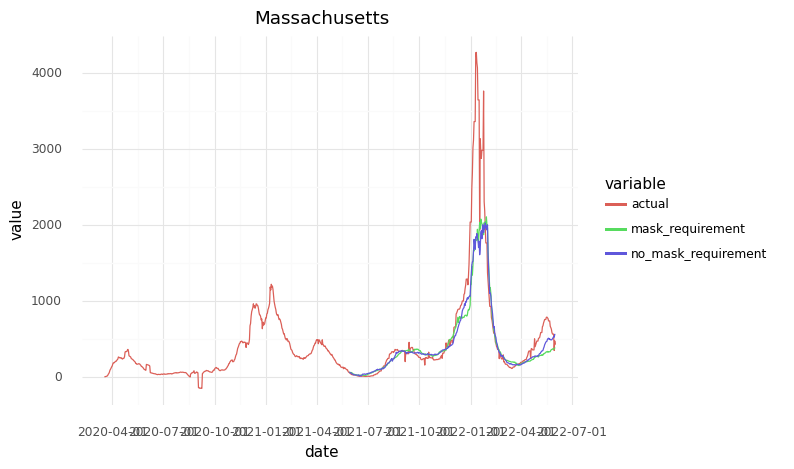

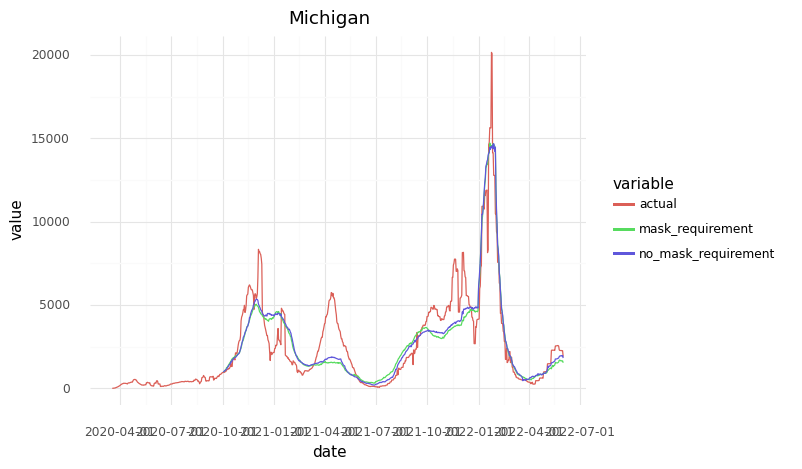

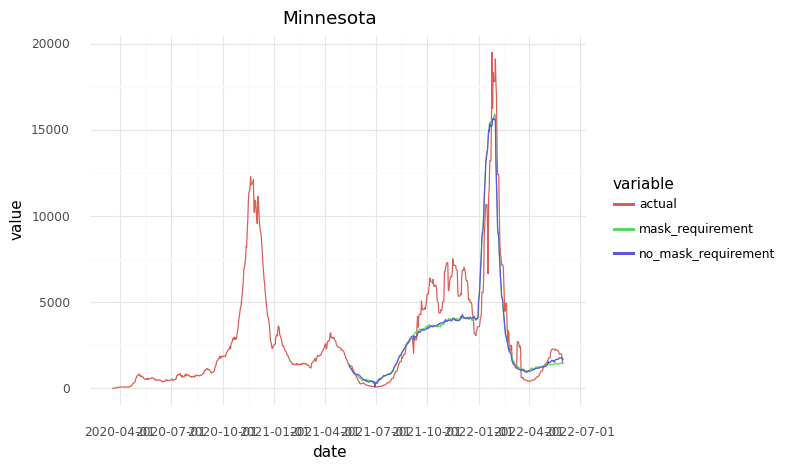

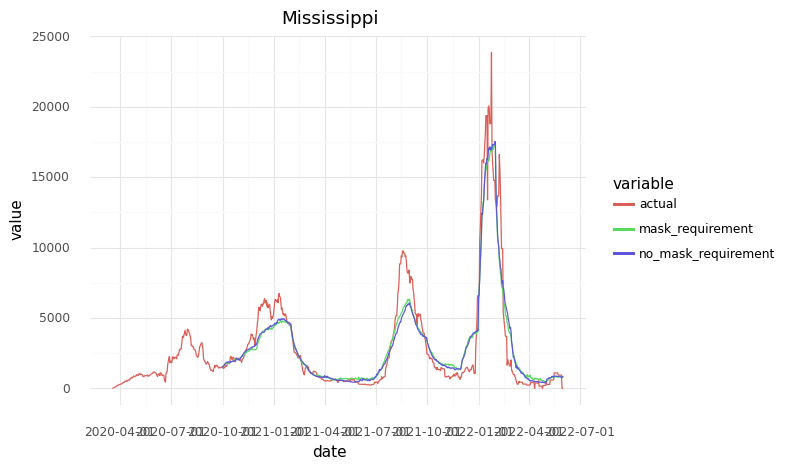

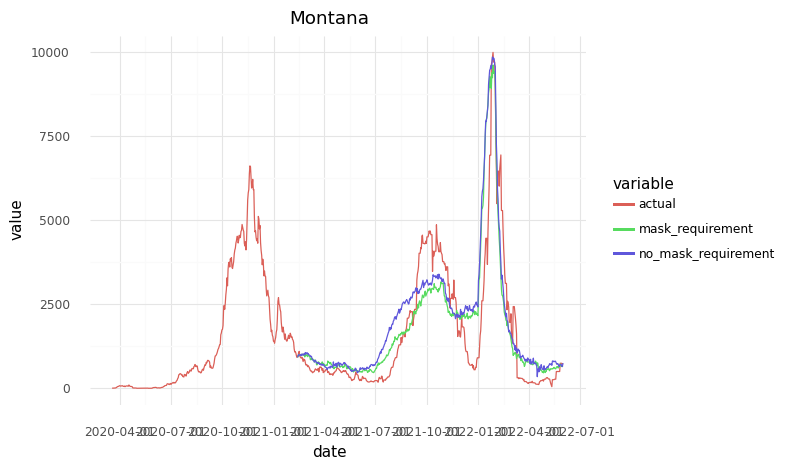

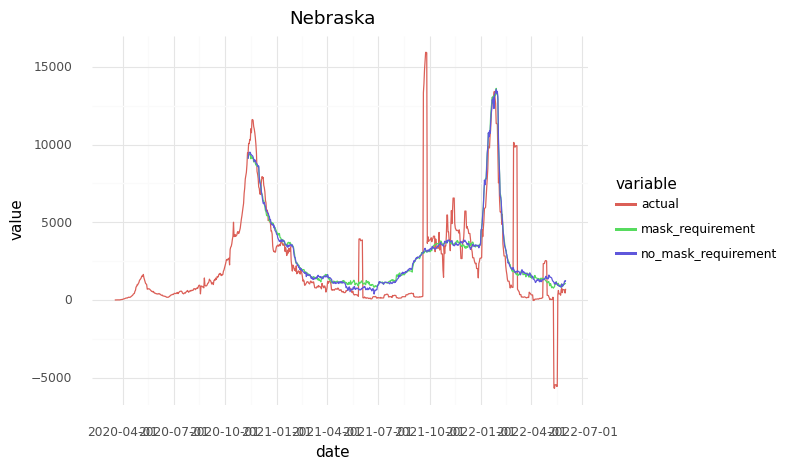

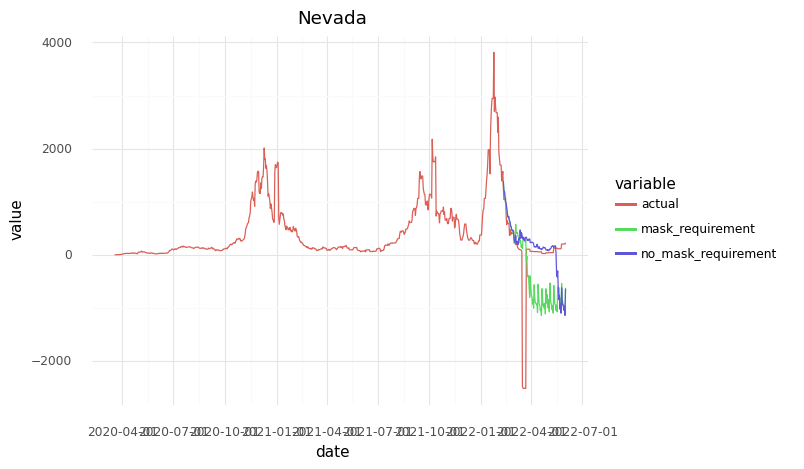

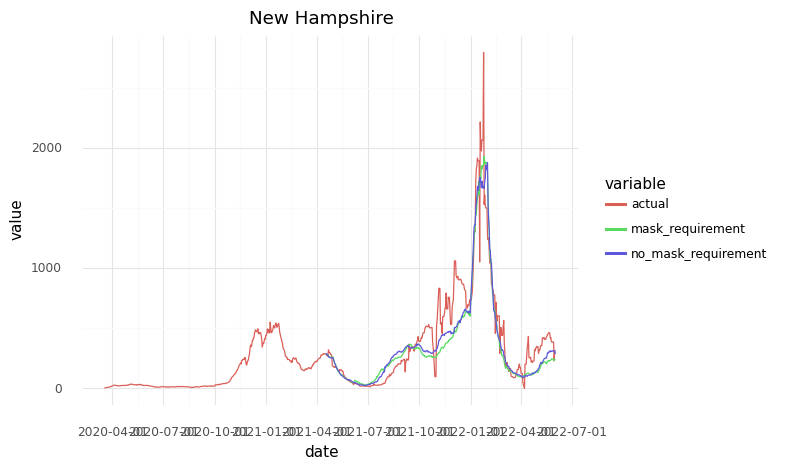

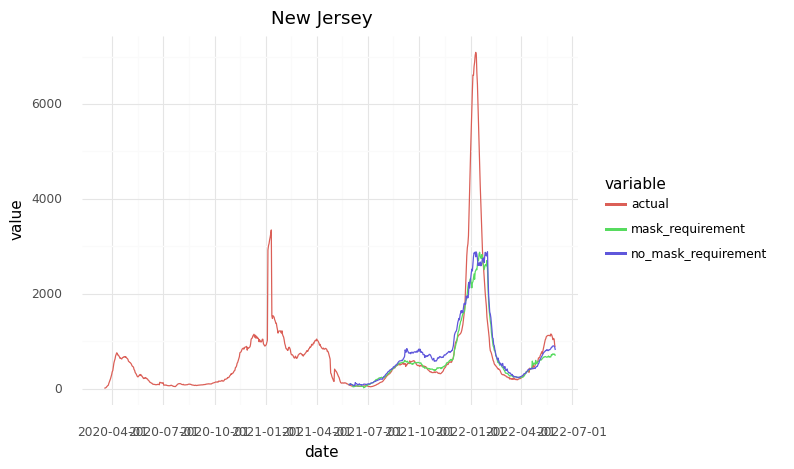

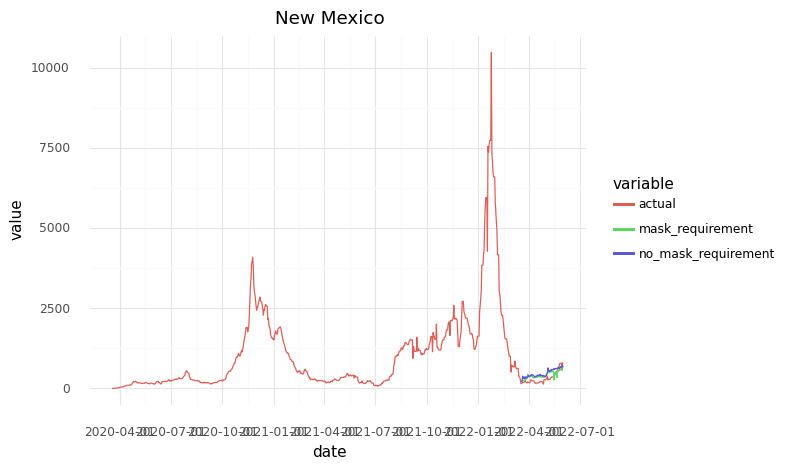

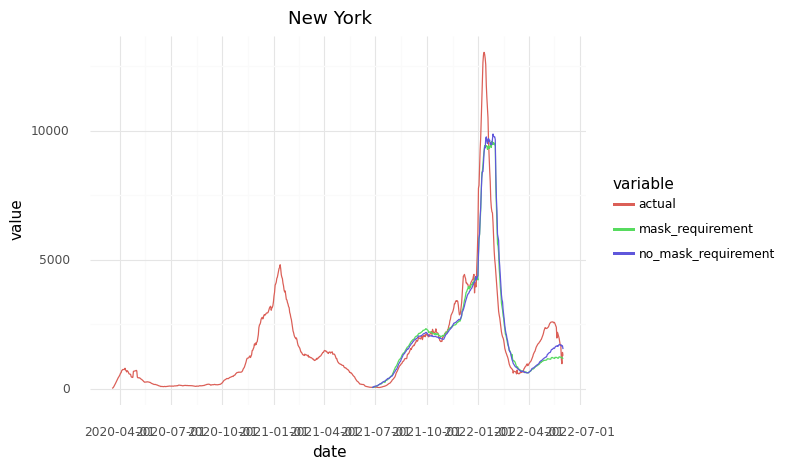

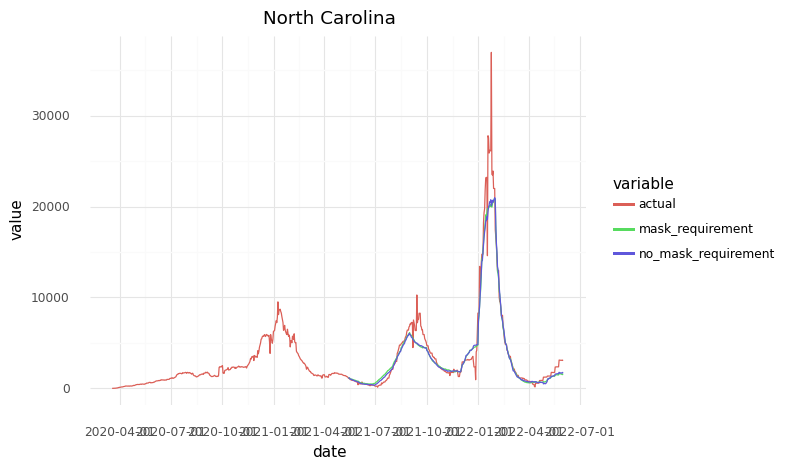

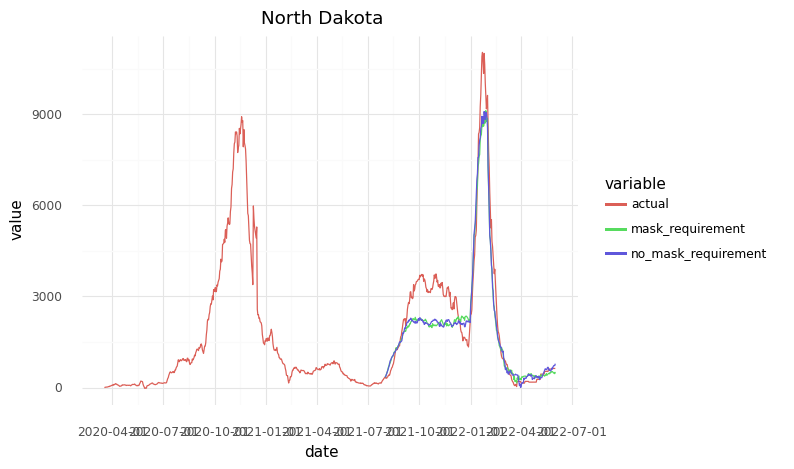

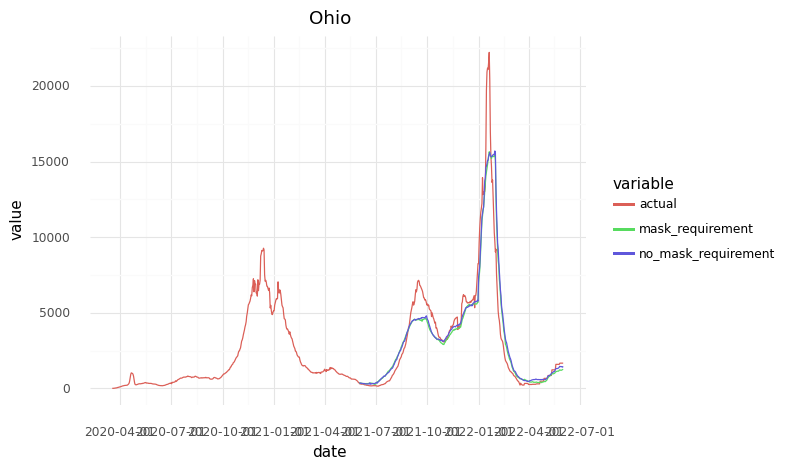

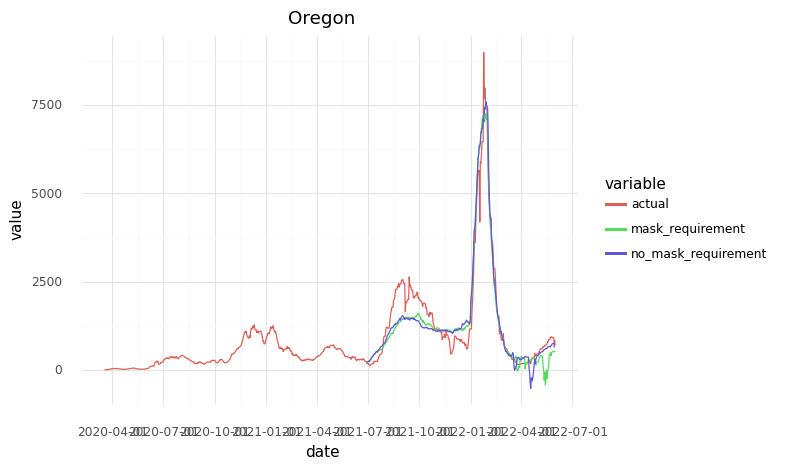

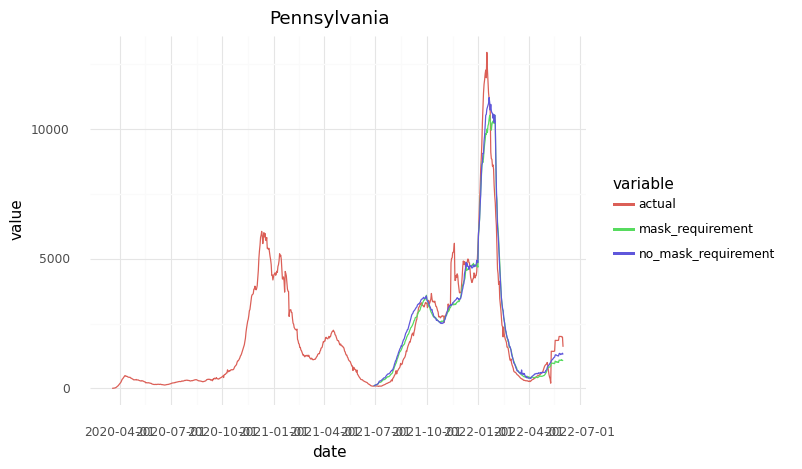

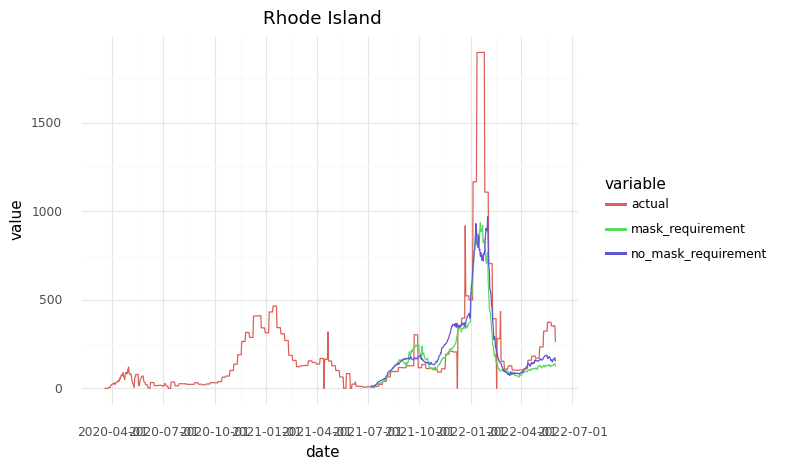

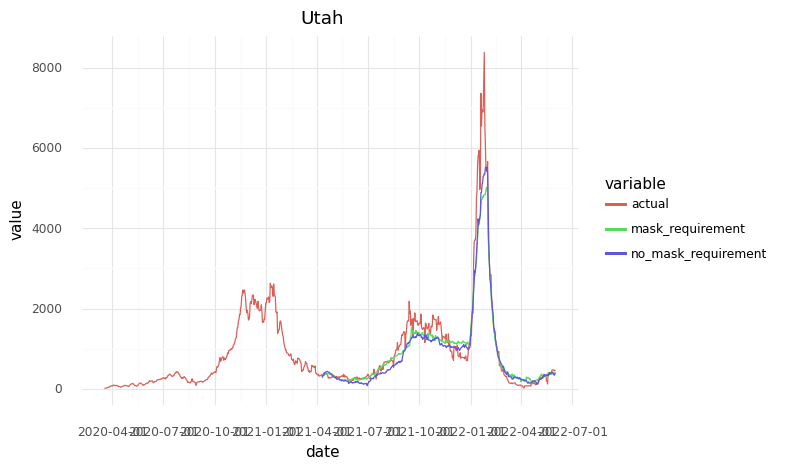

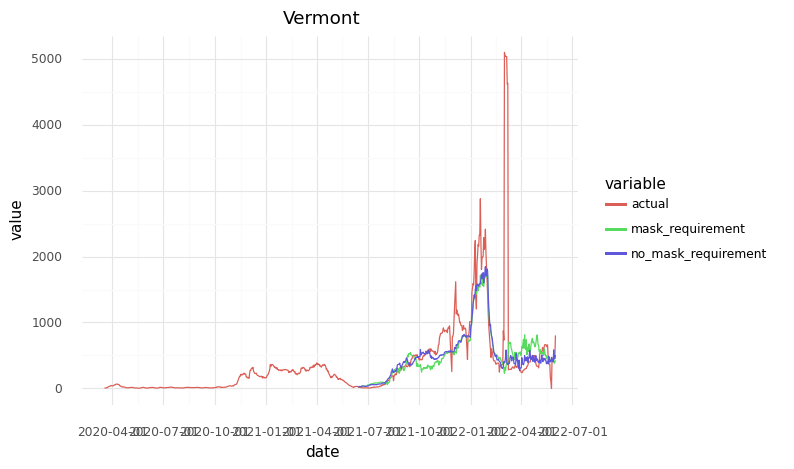

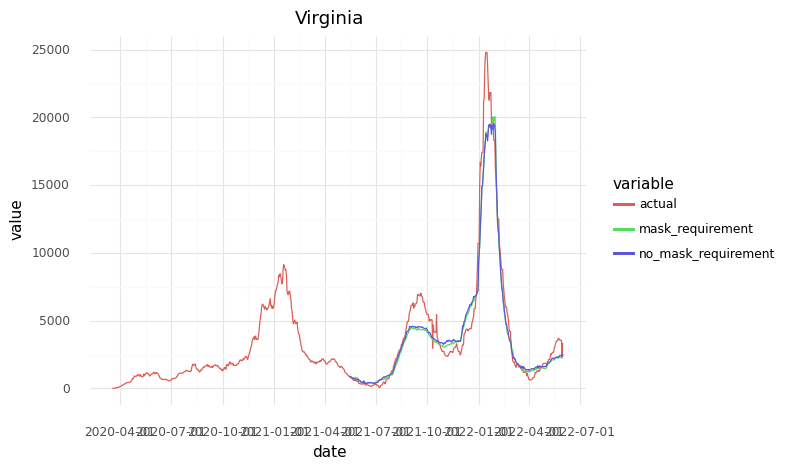

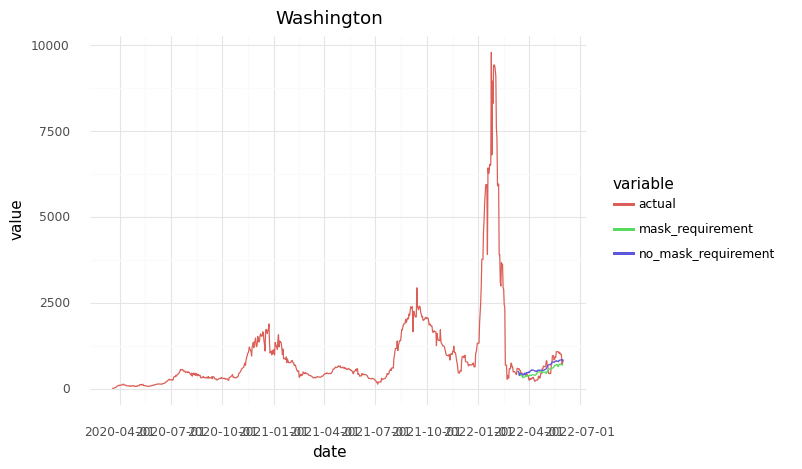

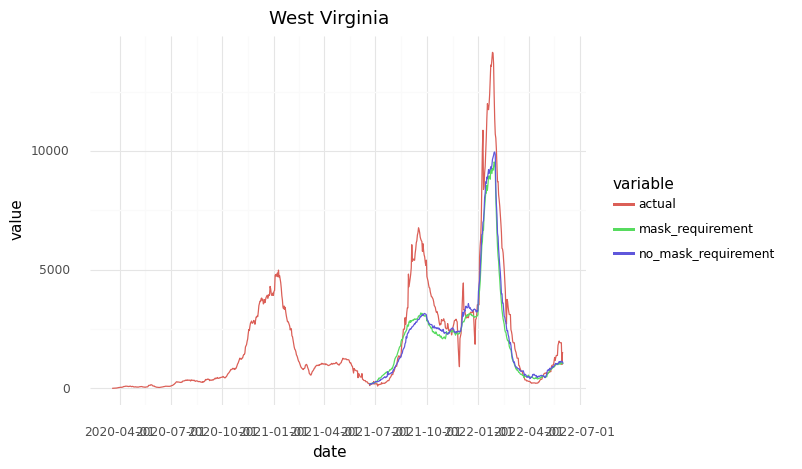

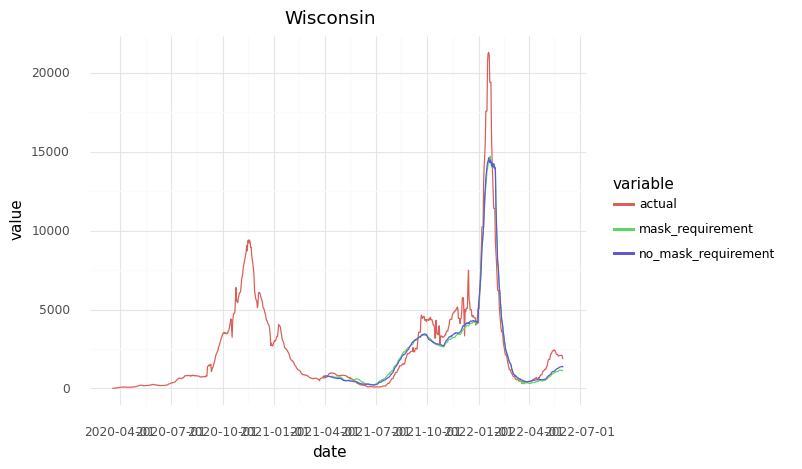

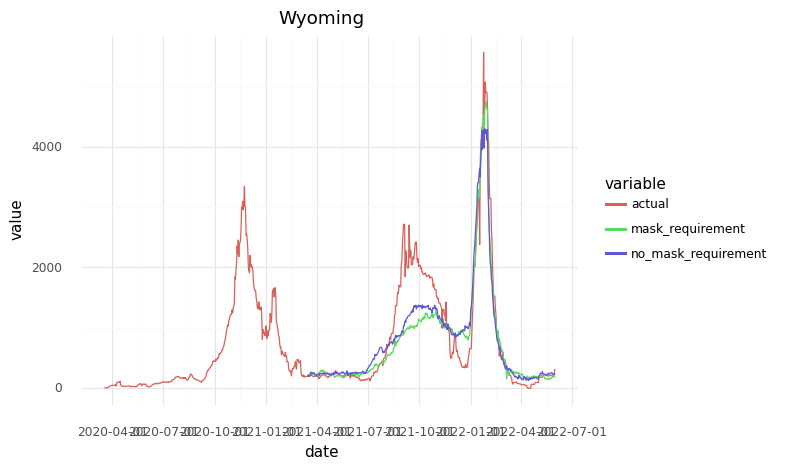

In [122]:
for state in sorted(final_results['state_code'].unique()):
    print(ggplot(final_results[final_results['state_code']==state],aes('date','value',color='variable')) + geom_line() + theme_minimal() + ggtitle(state))